In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 

In [2]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.   ,  2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133,
        0.067,  0.033, 0.37,7.4])

In [3]:
rs.sort()

In [4]:
1/rs

array([40.        , 30.3030303 , 20.        , 14.92537313, 10.        ,
        7.51879699,  5.        ,  3.4965035 ,  2.7027027 ,  2.        ,
        1.49925037,  1.        ,  0.75018755,  0.5       ,  0.4       ,
        0.30003   ,  0.2       ,  0.13513514,  0.1       ,  0.07500188,
        0.05      ])

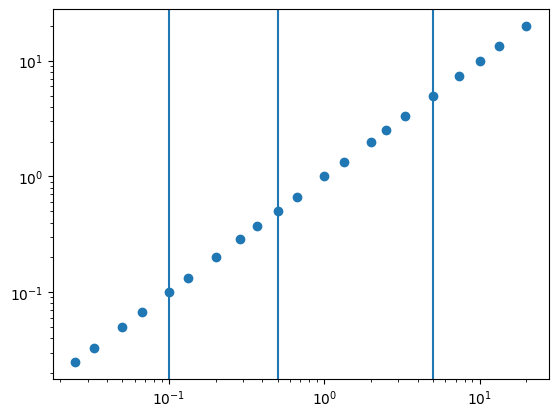

In [5]:
plt.scatter(rs,rs)
plt.yscale('log')
plt.xscale('log')
# plt.axhline(5)
# plt.axhline(0.5)
# plt.axhline(0.1)
plt.axvline(5)
plt.axvline(0.5)
plt.axvline(0.1)

In [6]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
WN2 = np.dot(WN, WN)
# prob = WN[:,1858]
prob = WN2[:,1858]
prob_2d = prob.reshape(-1,1)

In [7]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [8]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [9]:
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
           5.0:1 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
        0.067:3,  0.033:3, 0.37:2,7.4:0}

In [10]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

for r_idx in range(21):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:]*prob_2d
        matrix = torch.from_numpy(g_i_new)

        y = torch.tensor([r_c], dtype=torch.long)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

0.025 3
0.033 3
0.05 3
0.067 3
0.1 2
0.133 2
0.2 2
0.286 2
0.37 2
0.5 1
0.667 1
1.0 1
1.333 1
2.0 1
2.5 1
3.333 1
5.0 1
7.4 0
10.0 0
13.333 0
20.0 0


In [ ]:
len(dataset)

In [11]:
from torch.utils.data import random_split
all_data_len = len(dataset)
train_data, test_data = random_split(dataset, [int(all_data_len*0.8), int(all_data_len*0.2)])

In [12]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)        
        self.conv2 = GCNConv(128, 64) 
        self.conv3 = GCNConv(64, 16) 
        self.conv4 = GCNConv(16, 8) 
        self.classifier = Linear(8, num_classes)



    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        edge_index, edge_weight = add_self_loops(edge_index, edge_attr=edge_weight, num_nodes=x.size(0))

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        
        x = self.conv4(x, edge_index, edge_weight)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        x = self.classifier(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=50, num_classes=4).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
        loss = F.cross_entropy(output, label)     
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        optimizer.step() 
        
        results.append(output)
        
        _, predicted = torch.max(output, 1)  
        total += label.size(0)  
        correct += (predicted == label).sum().item()  
    accuracy = 100 * correct / total
    return loss_all / len(myloader.dataset), accuracy, results, y_true

counter = 0
count_epochs = 0
best = float("inf")
epochs = 90
patience = 10
loss_ep= []
ac_ep = []
 
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    loss, ac, myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
    ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss))
    if loss < best:
        best = loss
        counter = 0
    else:
        counter += 1
        count_epochs += 1
        
    if counter > patience:
        break
        # print(f"Epoch: {​​​​​​epoch:03d}​​​​​​, Loss: {​​​​​​loss:.4f}​​​​​​")
#     scheduler.step()
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
print("\n", "Stopped early at epoch: ", count_epochs)


/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epoch: 001, Loss: 1.3537:   1%|▏               | 1/90 [00:54<1:20:08, 54.03s/it]

Epoch: 001, Loss: 1.35370


Epoch: 002, Loss: 1.3268:   2%|▎               | 2/90 [01:48<1:19:33, 54.24s/it]

Epoch: 002, Loss: 1.32677


Epoch: 003, Loss: 1.3068:   3%|▌               | 3/90 [02:42<1:18:40, 54.25s/it]

Epoch: 003, Loss: 1.30684


Epoch: 004, Loss: 1.2542:   4%|▋               | 4/90 [03:37<1:18:00, 54.42s/it]

Epoch: 004, Loss: 1.25423


Epoch: 005, Loss: 1.3201:   6%|▉               | 5/90 [04:31<1:16:49, 54.22s/it]

Epoch: 005, Loss: 1.32007


Epoch: 006, Loss: 1.1708:   7%|█               | 6/90 [05:25<1:15:48, 54.15s/it]

Epoch: 006, Loss: 1.17080


Epoch: 007, Loss: 1.2726:   8%|█▏              | 7/90 [06:19<1:14:59, 54.21s/it]

Epoch: 007, Loss: 1.27262


Epoch: 008, Loss: 1.2568:   9%|█▍              | 8/90 [07:13<1:13:50, 54.03s/it]

Epoch: 008, Loss: 1.25683


Epoch: 009, Loss: 1.3367:  10%|█▌              | 9/90 [08:07<1:12:57, 54.04s/it]

Epoch: 009, Loss: 1.33669


Epoch: 010, Loss: 1.3299:  11%|█▋             | 10/90 [09:01<1:11:59, 53.99s/it]

Epoch: 010, Loss: 1.32993


Epoch: 011, Loss: 1.3267:  12%|█▊             | 11/90 [09:55<1:11:18, 54.16s/it]

Epoch: 011, Loss: 1.32674


Epoch: 012, Loss: 1.3195:  13%|██             | 12/90 [10:44<1:08:13, 52.48s/it]

Epoch: 012, Loss: 1.31945


Epoch: 013, Loss: 1.3053:  14%|██▏            | 13/90 [11:27<1:03:32, 49.51s/it]

Epoch: 013, Loss: 1.30527


Epoch: 014, Loss: 1.2987:  16%|██▎            | 14/90 [12:09<1:00:04, 47.42s/it]

Epoch: 014, Loss: 1.29867


Epoch: 015, Loss: 1.3485:  17%|██▊              | 15/90 [12:52<57:27, 45.96s/it]

Epoch: 015, Loss: 1.34845


Epoch: 016, Loss: 1.3151:  18%|███              | 16/90 [13:34<55:23, 44.92s/it]

Epoch: 016, Loss: 1.31508


Epoch: 016, Loss: 1.3151:  18%|██▋            | 16/90 [14:17<1:06:05, 53.59s/it]

Epoch: 017, Loss: 1.45791

 Stopped early at epoch:  12


In [ ]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    y_test = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            data, label = data.to(device), data.y.to(device)
            output = model(data)

            # Calculate loss
            loss = F.cross_entropy(output, label)
            test_loss += loss.item() * data.size(0)
            
            # Convert label to one-hot encoding
            one_hot_label = torch.zeros(label.size(0), 4).to(device)  # assuming 4 classes
            one_hot_label.scatter_(1, label.unsqueeze(1), 1)  # in-place operation to convert to one-hot
            y_test.extend(one_hot_label.cpu().numpy().tolist())
            
            # Store the scores
            y_scores.extend(output.cpu().numpy().tolist())

            # Get predictions
            _, predicted = output.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

    avg_loss = test_loss / total
    accuracy = 100 * correct / total

    print(f"Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)")

    return avg_loss, accuracy, y_test, y_scores

# Assuming you have a test_loader, model, and criterion already defined
test_loss, test_accuracy, y_test, y_score = test(model, testloader)

In [ ]:
from sklearn.metrics import roc_curve, auc
n_classes = 4
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
labels = {0:r'LS: $r > 5$',1:r'MS: $r \in [0.5,5]$',2:r'HS: $r \in [0.1,0.5)$',3:r'ES: $r<0.1$'}

In [ ]:
# y_test = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,0,0,0]])
# y_score = np.array([[0.5,0.2,0.1,0.2], [0.1,0.5,0.2,0.2], [0.2,0.1,0.5,0.2], [0.2,0.1,0.2,0.5], [0.6,0.1,0.1,0.2]])


y_test = np.array(y_test)
y_score = np.array(y_score)
fpr = dict()
tpr = dict()

# smoothed_fpr = dict()
# smoothed_tpr = dict()

roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#     smoothed_tpr[i] = moving_average(tpr[i], 5)
#     smoothed_fpr[i] = moving_average(fpr[i], 5)

# Plot the ROC curve
plt.rcParams['font.family'] = 'Times New Roman' 
plt.figure(dpi=600,figsize=(3.5,2.5))
for i in range(n_classes):
#     plt.plot(smoothed_fpr[i], smoothed_tpr[i], color = colors[i],
#              label='Class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))
    plt.plot(fpr[i], tpr[i], color = colors[i],
             label='{0} (AUC = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',lw=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',size=8)
plt.ylabel('True Positive Rate',size=8)
# plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right",fontsize=8,frameon=False)
plt.tight_layout()
# plt.show()
# plt.savefig('roc.pdf')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Example ROC data
fpr = np.linspace(0, 1, 100)
tpr = fpr**2 + (np.random.rand(100) - 0.5) * 0.1  # Just an example curve with noise

# Smoothed TPR
smoothed_tpr = moving_average(tpr, 5)
smoothed_fpr = moving_average(fpr, 5)

plt.plot(fpr, tpr, label="Original ROC", alpha=0.5)
plt.plot(smoothed_fpr, smoothed_tpr, label="Smoothed ROC", color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()